#### **Trabalho de Processamento de Big Data | Licenciatura em Ciência de Dados 2023/24 | CDB1**

Docente: João Oliveira<br><br>

- David Franco, nº110733

- Felipe Pereira, nº110861

- João Dias, nº110305

- Samuel Ricardo, nº110884<br><br>

https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region

*Version 9 (10.11 GB) | Created by John Holz | Data Update 2023/01/30*

# Modeling

## Problem formulation

Neste notebook o objetivo passará por desenvolver dois modelos (de aprendizagem supervionada) com dois objetivos distintos: 
- `Previsão de Temperatura`: As variáveis independentes incluirão informações como temperatura do ponto de orvalho, radiação global, velocidade e direção do vento, entre outras. O objetivo é prever a temperatura num determinado momento no futuro, com base nas condições meteorológicas atuais e históricas. O target será a temperatura média (obtida a partir das variáveis da temperatura minima e máxima registadas). 
- `Previsão da Precipitação`: Para prever a precipitação, será utilizado um modelo de classificação, como a Regressão Logística. O objetivo é classificar se haverá ou não precipitação num determinado período de tempo, com base em variáveis como humidade relativa, temperatura, direção e velocidade do vento, entre outras. Este modelo pode ser útil para alertar sobre a possibilidade de chuvas intensas ou eventos de tempestade e o target pode ser obtido do total de precipitação por hora (se maior que 0, será codificado com 1, cc 0)

### Setup inicial

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [2]:
# Criar a sessão de Spark

spark = SparkSession.builder \
    .appName("WeatherBrazilModeling") \
    .config("spark.sql.shuffle.partitions", 512) \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [3]:
spark

### Utils

In [4]:
def numeric_columns(df):
    cls_numeric = []
    for x, t in df.dtypes:
        if t in ['int', 'double']:
            cls_numeric.append(x)
    return cls_numeric


def plotCorrelationMatrix(df, annot=False):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap='coolwarm'
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As funções `numeric_columns(df)` e `plotCorrelationMatrix` identificam colunas numéricas e exibem a matriz de correlação das mesmas, respectivamente.

### Leitura do parquet gerado com `trabalho_final_limpeza`

In [5]:
!ls

all_stations.parquet  trabalho_final_limpeza.ipynb
datasets_originais    trabalho_final_modelo.ipynb
pbd_projeto_2024.pdf  trabalho_final_modelos.ipynb


In [6]:
# ler o parquet gerado na etapa anterior de limpeza
df_final = spark.read.parquet("all_stations.parquet")

Foi lido o parquet criado no notebook da limpeza de dados.

In [7]:
df_final.printSchema()
df_final.show()
df_final.count()

root
 |-- Index: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Hour: string (nullable = true)
 |-- TotalHourlyPrecipitationMm: double (nullable = true)
 |-- HourlyStationLevelAtmosphericPressureMb: double (nullable = true)
 |-- LastHourMaxAtmosphericPressureMb: double (nullable = true)
 |-- LastHourMinAtmosphericPressureMb: double (nullable = true)
 |-- HourlyDryBulbAirTemperatureC: double (nullable = true)
 |-- DewPointTemperatureC: double (nullable = true)
 |-- LastHourMaxTemperatureC: double (nullable = true)
 |-- LastHourMinTemperatureC: double (nullable = true)
 |-- LastHourMaxDewPointTemperatureC: double (nullable = true)
 |-- LastHourMinDewPointTemperatureC: double (nullable = true)
 |-- LastHourMaxRelativeHumidityPercentage: integer (nullable = true)
 |-- LastHourMinRelativeHumidityPercentage: integer (nullable = true)
 |-- HourlyRelativeHumidityPercentage: integer (nullable = true)
 |-- HourlyWindDirectionRadiusDegrees: integer (nullable = true)
 |-- Maximum

49759514

Estes comandos exibem a estrutura, as primeiras linhas e o número total de linhas no `df_final`.

In [8]:
# drop de colunas que não serão utilizadas
df_final = df_final.drop(*['Index', 'Latitude', 'Longitude'])

Neste chunk foram removidas as colunas que não iam ser utilizadas.

In [9]:
# seed = 5
# with_replacement = False
# fraction = 0.1      
# df_final = df_final.sample(withReplacement = with_replacement, fraction = fraction, seed = seed)

Este código encontra-se comentado porque não é relevante para a versão final . A amostragem foi útil apenas para o desenvolvimento, ajudando a identificar e a corrigir problemas de maneira mais rápida e eficiente.

## Previsão da temperatura média

In [10]:
# obter a temperatura média (target) a partir das nossas variaveis
df_final = df_final.withColumn("AverageTemperatureC", (col("LastHourMaxTemperatureC") + col("LastHourMinTemperatureC")) / 2)
df_final = df_final.drop(*["LastHourMaxTemperatureC", "LastHourMinTemperatureC"])
df_final.show()

+----------+-----+--------------------------+---------------------------------------+--------------------------------+--------------------------------+----------------------------+--------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------+--------------------------------+--------------------------------+-----------------+-----------------+------+-----+-------+-----------+------+-------------------+
|      Date| Hour|TotalHourlyPrecipitationMm|HourlyStationLevelAtmosphericPressureMb|LastHourMaxAtmosphericPressureMb|LastHourMinAtmosphericPressureMb|HourlyDryBulbAirTemperatureC|DewPointTemperatureC|LastHourMaxDewPointTemperatureC|LastHourMinDewPointTemperatureC|LastHourMaxRelativeHumidityPercentage|LastHourMinRelativeHumidityPercentage|HourlyRelativeHumidityPercentage|HourlyWindDirectionRadiusDegrees|MaximumWindGustMs|HourlyWindSpeedMs|Region|State|Station|StationCode|Height|AverageTemper

Este conjunto de comandos calcula a temperatura média com base nas nossas variáveis, atribuindo o resultado à coluna `AverageTemperatureC`. Por fim, são removidas as colunas `LastHourMaxTemperatureC` e `LastHourMinTemperatureC` do dataframe.

In [11]:
# split em treino e teste sets
df_train, df_test, df_validation = df_final.randomSplit([0.7, 0.15, 0.15], 123)

Divide o `df_final` em três conjuntos: treino, teste e validação, com proporções de 70%, 15% e 15%, respectivamente, utilizando a seed aleatória 123 para garantir reprodutibilidade.

In [12]:
# obter colunas numéricas
cols_numeric = numeric_columns(df_final)

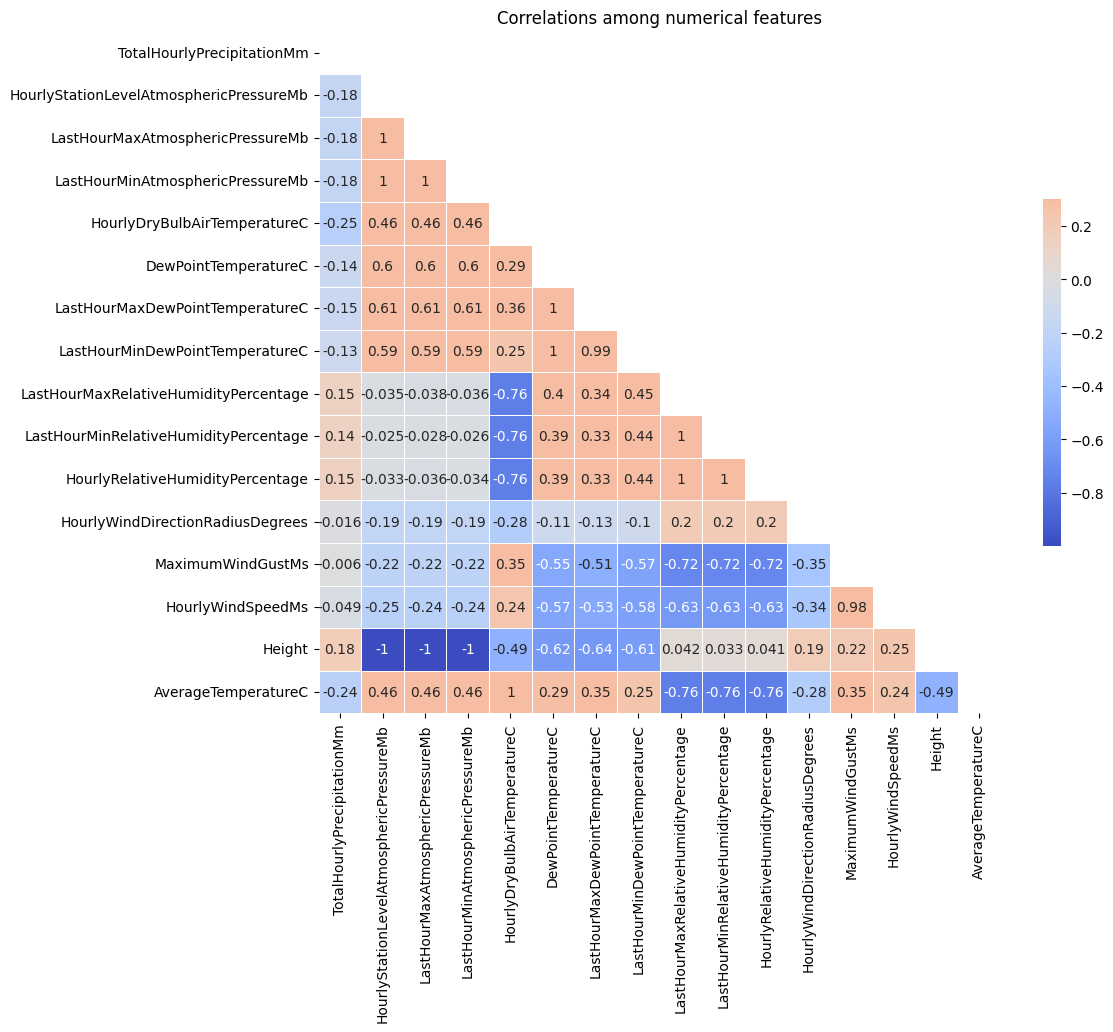

In [13]:
# Verificar as correlações entre as variáveis numéricas
df_for_model = df_final

# As colunas para calcular as correlações - tipos numéricos mas sem nulos
cols_corr = cols_numeric

# Assemble das colunas
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col, handleInvalid = "skip")  # "keep"
df_vector = assembler.transform(df_for_model).select(vector_col)

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

# Plot
df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix(df_plot, annot=True)
plt.title('Correlations among numerical features')
plt.show()

#### Análise da Matriz de Correlação

**Observações Gerais:**
1. **Correlação Positiva Alta:**
   - As variáveis `HourlyStationLevelAtmosphericPressureMb`, `LastHourMaxAtmosphericPressureMb`, `LastHourMinAtmosphericPressureMb` tem alta correlação positiva com as variáveis `DewPointTemperatureC`, `LastHourMaxDewPointTemperatureC` e `LastHourMinDewPointTemperatureC` (valores entre 0.59 e 0.61). Ou seja, isto indica que quando a pressão atmosférica aumenta, a temperatura do ponto de orvalho tende a aumentar também.
   - A velocidade do Vento descrita por`HourlyWindSpeedMs` também tem alta correlação positiva com `MaximumWindGustsMs` (0.98)

2. **Correlação Negativa Alta:**
   - A variável `HourlyDryBulbAirTemperatureC` tem alta correlação negativa com as variáveis `HourlyRelativeHumidityPercentage`, `LastHourMaxRelativeHumidityPercentage` e `LastHourMinRelativeHumidityPercentage` (-0.76) o que sugere que temperaturas mais altas estão associadas a níveis de humidade mais baixos 

3. **Correlação Próxima de Zero:**
   - Algumas variáveis apresentam correlação próxima de zero com a maioria das outras variáveis. Isto indica pouca ou nenhuma relação linear entre elas, como é o caso das variáveis `HourlyWindDirectionRadiusDegrees` e `TotalHourlyPrecipitationMm`

**Detalhes relevantes:**
- Todas as variáveis que têm uma correlação perfeita de 1 movem-se juntas (ex: `HourlyStationLevelAtmosphericPressureMb`, `LastHourMaxAtmosphericPressureMb`, `LastHourMinAtmosphericPressureMb`)
- A variável `Height` mostra uma correlação perfeita com as variáveis da pressão atmosférica, o que indica na sua totalidade que quanto maior for a altura menor vai ser a pressão

In [14]:
# features utilizadas para o RandomForestRegressor
cols_features = ['TotalHourlyPrecipitationMm', 'HourlyStationLevelAtmosphericPressureMb','DewPointTemperatureC', 'HourlyRelativeHumidityPercentage','HourlyWindDirectionRadiusDegrees']
vec_assembler = VectorAssembler(inputCols=cols_features, outputCol="unscaled_features") 

Procedemos à seleção dessas features uma vez que estas tinham uma relação significativa com o target (`AverageTemperatureC`).
Para evitar multicolinearidade escolhemos apenas uma entre as variáveis que têm `min` e `max` para o mesmo parâmetro, pois elas são altamente correlacionadas entre si.<br><br>

O `VectorAssembler` é um transformador que combina um dado número de colunas (features) em uma única coluna de vetores. Isso é necessário, pois muitos algoritmos de machine learning no Spark MLlib exigem que as features estejam representadas como vetores. 

- inputCols: colunas de entrada que queremos combinar
- outputCol: nova coluna que contém os vetores de features combinadas

In [15]:
# colocar todas as features na mesma escala
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

O `StandardScaler` é um estimador que ajusta e transforma os dados para que cada feature tenha uma média de o e uma variância correspondente a 1. Isso é importante para algoritmos que dependem da escala das features, pois garante que todas as features contribuam de forma equivalente.

- inputCol: coluna de entrada que contém as features não escaladas
- outputCol: coluna de saída que conterá as features escaladas

In [16]:
regressor = RandomForestRegressor(labelCol="AverageTemperatureC", seed=123)

O `RandomForestRegressor` é um algoritmo de machine learning que para realizar a regressão utiliza um conjunto de árvores de decisão. Este algoritmo é robusto a overfitting e pode capturar relações não lineares entre as features e a variável target.

- labelCol: coluna que contém o valor a tentar prever (`AverageTemperatureC`)
- seed: valor para garantir a reprodutibilidade dos resultados

In [17]:
pipeline = Pipeline(stages=[vec_assembler, scaler, regressor])

A `Pipeline` é uma maneira de encadear vários transformadores e estimadores numa única sequência de passos. Isso torna mais fácil criar processos de trabalho para machine learning, onde as transformações são aplicadas de maneira consistente e organizada.

- stages: lista de transformadores e estimadores que compõem a pipeline

In [18]:
pipeline_model = pipeline.fit(df_train)

Por fim, ajustamos o pipeline aos dados de treinamento de forma a treinar o modelo.

In [19]:
# fazer as previsões
df_prediction = pipeline_model.transform(df_test)

# verificar o schema
df_prediction.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Hour: string (nullable = true)
 |-- TotalHourlyPrecipitationMm: double (nullable = true)
 |-- HourlyStationLevelAtmosphericPressureMb: double (nullable = true)
 |-- LastHourMaxAtmosphericPressureMb: double (nullable = true)
 |-- LastHourMinAtmosphericPressureMb: double (nullable = true)
 |-- HourlyDryBulbAirTemperatureC: double (nullable = true)
 |-- DewPointTemperatureC: double (nullable = true)
 |-- LastHourMaxDewPointTemperatureC: double (nullable = true)
 |-- LastHourMinDewPointTemperatureC: double (nullable = true)
 |-- LastHourMaxRelativeHumidityPercentage: integer (nullable = true)
 |-- LastHourMinRelativeHumidityPercentage: integer (nullable = true)
 |-- HourlyRelativeHumidityPercentage: integer (nullable = true)
 |-- HourlyWindDirectionRadiusDegrees: integer (nullable = true)
 |-- MaximumWindGustMs: double (nullable = true)
 |-- HourlyWindSpeedMs: double (nullable = true)
 |-- Region: string (nullable = true)
 |-- State: string (null

Aplica o modelo pipeline previamente treinado para realizar previsões no `df_test`, armazenando os resultados no dataframe `df_prediction`. De seguida, apresenta a estrutura do dataframe resultante.

In [20]:
# verificar as previsões vs resultados reais
df_prediction.select('features', 'prediction', 'AverageTemperatureC').show(truncate=False)

+---------------------------------------------------------------------------------------------+------------------+-------------------+
|features                                                                                     |prediction        |AverageTemperatureC|
+---------------------------------------------------------------------------------------------+------------------+-------------------+
|[0.0,24.146139237855607,3.5497292553334803,4.808299966574194,2.7721253601109512]             |18.158963485434008|17.049999999999997 |
|[0.0,24.669545927815754,3.885798297258544,3.9160381171068175,1.5797037897691084]             |21.95225476829854 |22.049999999999997 |
|[0.0,25.34516782863167,4.368897545025822,4.064748425351381,2.364459865976988]                |24.081160642133074|24.549999999999997 |
|[0.0,26.878001706372114,4.704966586950885,4.659589658329631,2.619250799810715]               |23.85045274710317 |23.95              |
|[0.3163732606274644,24.437217448088546,3.8017810367772

Este comando exibe as previsões feitas pelo modelo (`prediction`) e os resultados reais (`AverageTemperatureC`) para cada instância no conjunto de teste. Isso permite uma comparação direta entre as previsões do modelo e os valores reais, no nosso caso os valores foram muito semelhantes.

In [21]:
# Previsões no conjunto de treino
df_train_prediction = pipeline_model.transform(df_train)

# Previsões no conjunto de teste
df_test_prediction = pipeline_model.transform(df_test)

# Calcular métricas no conjunto de treino
print("Métricas no conjunto de treino:")
for metric in ["rmse", "mse", "mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="AverageTemperatureC", 
                                    predictionCol="prediction", 
                                    metricName=metric)
    value = evaluator.evaluate(df_train_prediction)
    print(f"Train Metric {metric} = {value}")

# Calcular métricas no conjunto de teste
print("\nMétricas no conjunto de teste:")
for metric in ["rmse", "mse", "mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="AverageTemperatureC", 
                                    predictionCol="prediction", 
                                    metricName=metric)
    value = evaluator.evaluate(df_test_prediction)
    print(f"Test Metric {metric} = {value}")

Métricas no conjunto de treino:
Train Metric rmse = 2.3501171850305185
Train Metric mse = 5.523050783375769
Train Metric mae = 1.6555966365568495
Train Metric r2 = 0.8191443897665662

Métricas no conjunto de teste:
Test Metric rmse = 2.350464284770516
Test Metric mse = 5.524682353981774
Test Metric mae = 1.6559119406349716
Test Metric r2 = 0.8192204096259319


Este bloco de código realiza previsões nos conjuntos de treino e teste utilizando o modelo de pipeline previamente treinado. Em seguida, calcula e exibe várias métricas de avaliação de regressão, incluindo Root Mean Squared Error, Mean Squared Error, Mean Absolute Error e o R².

No geral, valores mais baixos de RMSE, MSE e MAE, e mais próximos de 1 para R², sugerem um melhor ajuste do modelo aos dados. Os resutados que obtivemos indicam um bom desempenho, com RMSE e MAE por volta dos 2°C e um R² em torno de 0.82, sugerindo que o modelo explica cerca de 82% da variabilidade nos dados.

### Saving the pipeline + validation set

In [22]:
pipeline.save("pipeline-RandomForestRegression")

In [23]:
pipeline_model.save("model-RandomForestRegression")

In [24]:
df_validation.write.mode("overwrite").parquet("regression-validation-set.parquet")

Este conjunto de comandos guarda o pipeline de pré-processamento e modelagem como "pipeline-RandomForestRegression", o modelo treinado como "model-RandomForestRegression", e os dados de validação são escritos no formato Parquet como "regression-validation-set.parquet".

## Previsão da precipitação

In [25]:
df_final_classification = df_final

In [26]:
# Verificar distribuição do target para o novo modelo
# Contar o número de observações onde TotalHourlyPrecipitationMm é 0
count_zero = df_final_classification.filter(col("TotalHourlyPrecipitationMm") == 0).count()

# Contar o número de observações onde TotalHourlyPrecipitationMm é maior que 0
count_greater_than_zero = df_final_classification.filter(col("TotalHourlyPrecipitationMm") > 0).count()

print(f"Número de instÂncias sem precipitação: {count_zero}")
print(f"Número de instÂncias com precipitação: {count_greater_than_zero}")

Número de instÂncias sem precipitação: 46201953
Número de instÂncias com precipitação: 3557561


Conta o número de instâncias com e sem precipitação no `df_final_classification` e dá print dos resultados, mostrando a distribuição do target.

In [27]:
# Primeiro precisamos de codifir a coluna binária 'Rains' onde 0 = não chove e 1 = chove que será o target do modelo
df_final_classification = df_final_classification.withColumn("Rains", when(col("TotalHourlyPrecipitationMm") > 0, 1).otherwise(0))
df_final_classification = df_final_classification.drop("TotalHourlyPrecipitationMm") # drop da coluna que usada para definir o target


Codifica a coluna binária 'Rains', onde 0 representa "não chove" e 1 representa "chove", que será o target do modelo. Em seguida, remove a coluna `TotalHourlyPrecipitationMm`, que foi usada para definir o target.

In [28]:
df_final_classification.show()

+----------+-----+---------------------------------------+--------------------------------+--------------------------------+----------------------------+--------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------+--------------------------------+--------------------------------+-----------------+-----------------+------+-----+-------+-----------+------+-------------------+-----+
|      Date| Hour|HourlyStationLevelAtmosphericPressureMb|LastHourMaxAtmosphericPressureMb|LastHourMinAtmosphericPressureMb|HourlyDryBulbAirTemperatureC|DewPointTemperatureC|LastHourMaxDewPointTemperatureC|LastHourMinDewPointTemperatureC|LastHourMaxRelativeHumidityPercentage|LastHourMinRelativeHumidityPercentage|HourlyRelativeHumidityPercentage|HourlyWindDirectionRadiusDegrees|MaximumWindGustMs|HourlyWindSpeedMs|Region|State|Station|StationCode|Height|AverageTemperatureC|Rains|
+----------+-----+----------------

Exibe o `df_final_classification` para verificar as alterações feitas no dataframe.

In [29]:
## Aplicar undersampling para corrigir o imbalance no target (nas primeiras iterações do modelos sem corrigir o desbalanceamento, não estava a ser possível prever quando chovia que é o objetivo)
# Calcula o número de instâncias em cada classe
count_no_rain = df_final_classification.filter(F.col("Rains") == 0).count()
count_rain = df_final_classification.filter(F.col("Rains") == 1).count()

# Determina o número mínimo de instâncias para cada classe (igual ao número de instâncias na classe minoritária)
min_count = min(count_no_rain, count_rain)

# Aplica undersampling
df_final_classification = df_final_classification.filter(F.col("Rains") == 0).sample(withReplacement=False, fraction=min_count/count_no_rain, seed=123).union(
                  df_final_classification.filter(F.col("Rains") == 1))

# Exibe a contagem de instâncias após o undersampling
df_final_classification.groupBy("Rains").count().show()

+-----+-------+
|Rains|  count|
+-----+-------+
|    0|3558204|
|    1|3557561|
+-----+-------+



Estas linhas de código aplicam undersampling para corrigir o desbalanceamento no target 'Rains'. Primeiro, calculam o número de instâncias em cada classe, determinam o número mínimo de instâncias para cada classe e aplicam undersampling na classe maioritária de forma a igualar o número de instâncias à classe minoritária. Por fim, exibem a contagem de instâncias após o undersampling, garantindo que as duas classes tenham o mesmo número de instâncias.

In [30]:
df_final_classification.show()
df_final_classification.count()

+----------+-----+---------------------------------------+--------------------------------+--------------------------------+----------------------------+--------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------+--------------------------------+--------------------------------+-----------------+-----------------+------+-----+-------+-----------+------+-------------------+-----+
|      Date| Hour|HourlyStationLevelAtmosphericPressureMb|LastHourMaxAtmosphericPressureMb|LastHourMinAtmosphericPressureMb|HourlyDryBulbAirTemperatureC|DewPointTemperatureC|LastHourMaxDewPointTemperatureC|LastHourMinDewPointTemperatureC|LastHourMaxRelativeHumidityPercentage|LastHourMinRelativeHumidityPercentage|HourlyRelativeHumidityPercentage|HourlyWindDirectionRadiusDegrees|MaximumWindGustMs|HourlyWindSpeedMs|Region|State|Station|StationCode|Height|AverageTemperatureC|Rains|
+----------+-----+----------------

7115765

Este conjunto de comandos exibe o dataframe após a aplicação do undersampling e conta o número total de instâncias.

In [31]:
# seleção de features para o SVM
cols_features = ['HourlyStationLevelAtmosphericPressureMb','DewPointTemperatureC', 'HourlyRelativeHumidityPercentage','HourlyWindDirectionRadiusDegrees', 'AverageTemperatureC']
vec_assembler = VectorAssembler(inputCols=cols_features, outputCol="features") 

Este código seleciona as características para o modelo SVM, especificando as colunas relevantes e as agrupa em um único vetor usando o `VectorAssembler`.

In [32]:
# treino e teste split
df_train, df_test, df_validation_c = df_final_classification.randomSplit([0.7, 0.15, 0.15], 123)

Divide o `df_final_classification` em três conjuntos: treino, teste e validação, com proporções de 70%, 15% e 15%, respectivamente, utilizando a seed aleatória 123.

In [33]:
svm = LinearSVC(featuresCol="features", labelCol="Rains")

Cria um modelo `LinearSVC`, usando as features como 'featuresCol' e o target como 'labelCol'.

In [34]:
pipeline = Pipeline(stages=[vec_assembler, svm])

Cria um pipeline de transformação e modelagem, com as etapas de transformação das features usando o `VectorAssembler` e modelagem usando o `LinearSVC`.

In [35]:
## Tuning dos paramêtros do modelo
# grid de parâmetros
param_grid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 50, 100]) \
    .addGrid(svm.regParam, [0.1, 0.01, 0.001]) \
    .build()

# tuning dos params
tvs = TrainValidationSplit(estimator=pipeline,
                            estimatorParamMaps=param_grid,
                            evaluator=MulticlassClassificationEvaluator(labelCol="Rains", metricName="weightedRecall"),
                            trainRatio=0.8, 
                            seed=123)

# TrainValidationSplit (a variavel pipeline_model já contem o modelo ajustado com os melhores hiperparametros disponiveis -> no chunk seguinte é possivel ver todas as iterações feitas no modelo e respetivos scores de recall (que é o nosso objetivo))
pipeline_model = tvs.fit(df_train)

O código executa o tuning dos parâmetros do modelo SVM, explorando diferentes valores para maxIter e regParam usando o TrainValidationSplit. O modelo ajustado com os melhores hiperparâmetros é então armazenado na variável pipeline_model.

In [36]:
# resultados para todas as iterações
validation_metrics = pipeline_model.validationMetrics

# parâmetros testados em cada iteração com o respectivo recall
for i, (params, recall) in enumerate(zip(pipeline_model.getEstimatorParamMaps(), validation_metrics)):
    print("Iteration", i + 1)
    for param, value in params.items():
        print(param.name, ":", value)
    print("Recall:", recall)
    print()

Iteration 1
maxIter : 10
regParam : 0.1
Recall: 0.744208873381363

Iteration 2
maxIter : 10
regParam : 0.01
Recall: 0.7603748999104846

Iteration 3
maxIter : 10
regParam : 0.001
Recall: 0.7632763656128091

Iteration 4
maxIter : 50
regParam : 0.1
Recall: 0.7440420993832376

Iteration 5
maxIter : 50
regParam : 0.01
Recall: 0.7611866673230463

Iteration 6
maxIter : 50
regParam : 0.001
Recall: 0.7658764325233408

Iteration 7
maxIter : 100
regParam : 0.1
Recall: 0.7440420993832376

Iteration 8
maxIter : 100
regParam : 0.01
Recall: 0.7611896813109642

Iteration 9
maxIter : 100
regParam : 0.001
Recall: 0.7668208154042913



Dá print dos resultados de todas as iterações do tuning de parâmetros, exibindo os parâmetros testados em cada iteração junto com o recall correspondente. Cada iteração é numerada e os resultados são apresentados de forma clara para avaliação.

In [37]:
predictions = pipeline_model.transform(df_test)

Realiza previsões no conjunto de teste `df_test` usando o modelo ajustado `pipeline_model` e armazena os resultados no dataframe `predictions`.

In [38]:
predictions.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Hour: string (nullable = true)
 |-- HourlyStationLevelAtmosphericPressureMb: double (nullable = true)
 |-- LastHourMaxAtmosphericPressureMb: double (nullable = true)
 |-- LastHourMinAtmosphericPressureMb: double (nullable = true)
 |-- HourlyDryBulbAirTemperatureC: double (nullable = true)
 |-- DewPointTemperatureC: double (nullable = true)
 |-- LastHourMaxDewPointTemperatureC: double (nullable = true)
 |-- LastHourMinDewPointTemperatureC: double (nullable = true)
 |-- LastHourMaxRelativeHumidityPercentage: integer (nullable = true)
 |-- LastHourMinRelativeHumidityPercentage: integer (nullable = true)
 |-- HourlyRelativeHumidityPercentage: integer (nullable = true)
 |-- HourlyWindDirectionRadiusDegrees: integer (nullable = true)
 |-- MaximumWindGustMs: double (nullable = true)
 |-- HourlyWindSpeedMs: double (nullable = true)
 |-- Region: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Station: string (nullable = true)
 |-- S

In [39]:
predictions.select('features', 'prediction', 'Rains').show(truncate=False)

+------------------------------------------+----------+-----+
|features                                  |prediction|Rains|
+------------------------------------------+----------+-----+
|[947.4,21.7,88.0,254.0,23.85]             |1.0       |0    |
|[948.6,20.4,89.0,171.0,22.5]              |1.0       |0    |
|[907.9,18.7,89.0,32.0,20.5]               |1.0       |0    |
|[1009.7,22.6,91.0,12.0,24.200000000000003]|1.0       |0    |
|[969.2,20.8,88.0,30.0,22.65]              |1.0       |0    |
|[979.3,22.2,80.0,233.0,25.1]              |0.0       |0    |
|[949.7,19.7,74.0,342.0,24.25]             |0.0       |0    |
|[903.2,17.6,69.0,285.0,22.799999999999997]|0.0       |0    |
|[846.3,15.6,94.0,114.0,16.5]              |1.0       |0    |
|[944.4,19.9,65.0,8.0,26.5]                |0.0       |0    |
|[957.7,20.3,67.0,26.0,26.1]               |0.0       |0    |
|[895.8,17.6,57.0,344.0,26.549999999999997]|0.0       |0    |
|[900.0,20.0,93.0,34.0,22.4]               |1.0       |0    |
|[1006.8

Exibe as features usadas para fazer as previsões, as previsões feitas pelo modelo `prediction` e o valor real do target `Rains` para cada instância no conjunto de teste. Isso permite uma comparação direta entre as previsões do modelo e os valores reais.

In [40]:
# obter os TN, TP, FP, FN
n = predictions.count()
tp = predictions.filter((F.col('Rains') == 1) & (F.col('prediction') == 1.0)).count()
tn = predictions.filter((F.col('Rains') == 0) & (F.col('prediction') == 0.0)).count()
fp = predictions.filter((F.col('Rains') == 0) & (F.col('prediction') == 1.0)).count()
fn = predictions.filter((F.col('Rains') == 1) & (F.col('prediction') == 0.0)).count()

print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("Total:", n)

True Positives (TP): 466963
True Negatives (TN): 351549
False Positives (FP): 182510
False Negatives (FN): 66272
Total: 1067294


Calcula e mostra os valores de TP, TN, FP e FN com base nas previsões do modelo e nos valores reais do target no conjunto de teste, além do total de instâncias no conjunto de teste. Essas métricas são fundamentais para avaliar o desempenho do modelo de classificação.

In [41]:
# avaliar o modelo com recurso à AUC 
binary_evaluator = BinaryClassificationEvaluator(labelCol="Rains", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# outras métricas de performance do modelo
evaluator = MulticlassClassificationEvaluator(labelCol="Rains", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

AUC: 0.8342663225805826
Accuracy: 0.7669039646058162
Recall: 0.7669039646058162
Precision: 0.7802343342877323
F1 Score: 0.7641262874163522


O modelo alcançou uma AUC de aproximadamente 0.83, indicando uma boa capacidade de distinguir entre as classes positiva e negativa. As métricas de accuracy, recall e F1-Score estão em torno de 0.77, enquanto a precisão é ligeiramente mais alta, em torno de 0.78. Esses resultados sugerem um desempenho geral sólido na classificação binária.

### Saving the pipeline

In [42]:
pipeline.save("pipeline-svm")

In [43]:
pipeline_model.save("model-svm")

In [44]:
df_validation_c.write.mode("overwrite").parquet("classification-validation-set.parquet")

Estes comandos guardam o pipeline de classificação como "pipeline-svm", o modelo treinado como "model-svm", e os dados de validação em formato Parquet como "classification-validation-set.parquet".